# Look at expression similarity and connectivity similarity vs distance


In [6]:
import pygest as ge

In [7]:
data = ge.Data('/data')

2020-04-02 11:27:51 [INFO] | PyGEST has initialized logging, and is running on host 'cardano'
2020-04-02 11:27:51 [INFO] | Found 9 donors in /data/sourcedata/participants.tsv


In [8]:
""" Load expression data from disk. """

import pickle

# Load data
expr_all = data.expression()
expr = data.expression(probes='fornito', samples='glasser')
with open('/data/conn/hcp_niftismooth_conn_sim.df', 'rb') as f:
    conn_all = pickle.load(f)
print("Loaded [{:,} x {:,}] expression dataframe and [{:,} x {:,}] connectivity similarity matrix.".format(
    expr.shape[0], expr.shape[1], conn_all.shape[0], conn_all.shape[1],
))
print("All available expression is [{:,} x {:,}]".format(expr_all.shape[0], expr_all.shape[1]))

# Match data
overlapping_samples = [well_id for well_id in conn_all.index if well_id in expr.columns]
expr = expr.loc[:, overlapping_samples]
conn = conn_all.loc[overlapping_samples, overlapping_samples]
print("Matching loci result in [{:,} x {:,}] expression dataframe and [{:,} x {:,}] connectivity similarity matrix.".format(
    expr.shape[0], expr.shape[1], conn.shape[0], conn.shape[1],
))


Loaded [15,745 x 1,280] expression dataframe and [2,731 x 2,731] connectivity similarity matrix.
All available expression is [58,692 x 3,702]
Matching loci result in [15,745 x 1,139] expression dataframe and [1,139 x 1,139] connectivity similarity matrix.


In [19]:
""" Create distance and distance-similarity matrices. """

from pygest.algorithms import make_similarity


# Create matching distance matrix
dist_all = data.distance_dataframe(expr_all.columns)
dist = data.distance_dataframe(overlapping_samples)

# Convert dist to similarity matrix
dist_sim = make_similarity(dist)

# And save them
dist.to_pickle("/data/conn/glasser-wellids-distances.df")
dist.to_pickle("/home/mike/ge_data/conn/glasser-wellids-distances.df")
dist_sim.to_pickle("/data/conn/glasser-wellids-distances_sim.df")
dist_sim.to_pickle("/home/mike/ge_data/conn/glasser-wellids-distances_sim.df")


Building distance matrix from 3702 samples, which resulted in (3702, 3) df
Building distance matrix from 1139 samples, which resulted in (1139, 3) df


In [39]:
# Create proximity (inverse distance) matrix

import math


def inverse_dist(d):
    # The minimum distance should be 1mm, but the diagonal has 0mm distances. Cap them at 1.0 and avoid div/0 errors.
    return 1 if d <= 1 else 1/d
def inverse_ln_dist(d):
    # The minimum distance should be 1mm, but the diagonal has 0mm distances. Cap them at 1.0 and avoid div/0 errors.
    return 1 if d <= math.e else 1/math.log(d)
prox_all = dist_all.applymap(inverse_dist)
prox = dist.applymap(inverse_dist)
prox_ln = dist.applymap(inverse_ln_dist)

prox_all.to_pickle("/data/conn/all-proximity.df")
prox_all.to_pickle("/home/mike/ge_data/conn/all-proximity.df")
prox.to_pickle("/data/conn/glasser-wellids-proximity.df")
prox.to_pickle("/home/mike/ge_data/conn/glasser-wellids-proximity.df")
prox_ln.to_pickle("/data/conn/glasser-wellids-log-proximity.df")
prox_ln.to_pickle("/home/mike/ge_data/conn/glasser-wellids-log-proximity.df")


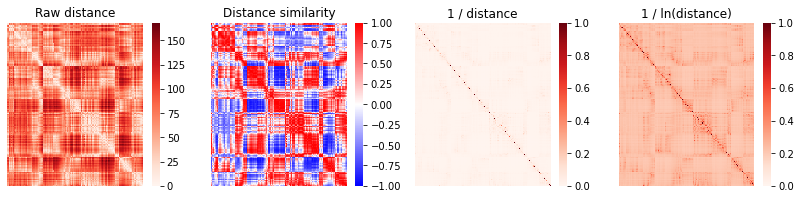

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=4, figsize=(14, 3))
sns.heatmap(dist, cmap='Reds', ax=axes[0])
axes[0].set_title("Raw distance")
sns.heatmap(dist_sim, vmin=-1.0, vmax=1.0, center=0.0, cmap='bwr', ax=axes[1])
axes[1].set_title("Distance similarity")
sns.heatmap(prox, vmin=0.0, vmax=1.0, cmap='Reds', ax=axes[2])
axes[2].set_title("1 / distance")
sns.heatmap(prox_ln, vmin=0.0, vmax=1.0, cmap='Reds', ax=axes[3])
axes[3].set_title("1 / ln(distance)")
for ax in axes:
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
fig.savefig("distance_and_distance-similarity.png")

In [31]:
import numpy as np
np.sum(prox_ln.to_numpy().flatten() > 2.0)

30

In [32]:
math.e

2.718281828459045

In [5]:
""" Vectorize data. """

import numpy as np

# Transform the data feeding into our results, Glasser loci & Fornito probes
expr_mat = np.corrcoef(expr.values, rowvar=False)
expr_vec = expr_mat[np.tril_indices(n=expr_mat.shape[0], k=-1)]

conn_mat = conn.values
conn_vec = conn_mat[np.tril_indices(n=conn_mat.shape[0], k=-1)]

dist_mat = dist.values
dist_vec = dist_mat[np.tril_indices(n=dist_mat.shape[0], k=-1)]

# And the great big all-included sets
expr_all_mat = np.corrcoef(expr_all.values, rowvar=False)
expr_all_vec = expr_all_mat[np.tril_indices(n=expr_all_mat.shape[0], k=-1)]

conn_all_mat = conn_all.values
conn_all_vec = conn_all_mat[np.tril_indices(n=conn_all_mat.shape[0], k=-1)]

dist_all_mat = dist_all.values
dist_all_vec = dist_all_mat[np.tril_indices(n=dist_all_mat.shape[0], k=-1)]

In [6]:
""" Define distribution histograms and kde curves for each vector. """

import seaborn as sns
import matplotlib.pyplot as plt

def dist_trio(ev, cv, dv, desc=""):
    fig, axes = plt.subplots(ncols=3, figsize=(12, 5))

    ev = ev[np.isfinite(ev)]
    sns.distplot(ev, color='gray', ax=axes[0])
    axes[0].set_title("E ({:,})".format(len(ev)))
    cv = cv[np.isfinite(cv)]
    sns.distplot(cv, color='gray', ax=axes[1])
    axes[1].set_title("C ({:,})".format(len(cv)))
    dv = dv[np.isfinite(dv)]
    sns.distplot(dv, color='gray', ax=axes[2])
    axes[2].set_title("D ({:,})".format(len(dv)))

    fig.suptitle(desc)
    fig.subplots_adjust(wspace=0.4)
    fig.savefig("./dists_{}.png".format(desc.lower().replace(" ", "_").replace(",", "")))
    
    return fig, axes

In [7]:
""" Define distribution histograms and kde curves for overlapping vectors. """

import seaborn as sns
import matplotlib.pyplot as plt

def dist_trio_overlapping(eva, ev, cva, cv, dva, dv, desc=""):
    fig, axes = plt.subplots(ncols=3, figsize=(12, 5))

    eva = eva[np.isfinite(eva)]
    sns.distplot(eva, color='gray', ax=axes[0])
    ev = ev[np.isfinite(ev)]
    sns.distplot(ev, color='blue', ax=axes[0])
    axes[0].set_title("E ({:,} & {:,})".format(len(eva), len(ev)))
    
    cva = cva[np.isfinite(cva)]
    sns.distplot(cva, color='gray', ax=axes[1])
    cv = cv[np.isfinite(cv)]
    sns.distplot(cv, color='blue', ax=axes[1])
    axes[1].set_title("C ({:,} & {:,})".format(len(cva), len(cv)))
    
    dva = dva[np.isfinite(dva)]
    sns.distplot(dva, color='gray', ax=axes[2])
    dv = dv[np.isfinite(dv)]
    sns.distplot(dv, color='blue', ax=axes[2])
    axes[2].set_title("D ({:,} & {:,})".format(len(dva), len(dv)))

    fig.suptitle(desc)
    fig.subplots_adjust(wspace=0.4)
    fig.savefig("./dists_ol_{}.png".format(desc.lower().replace(" ", "_").replace(",", "")))
    
    return fig, axes

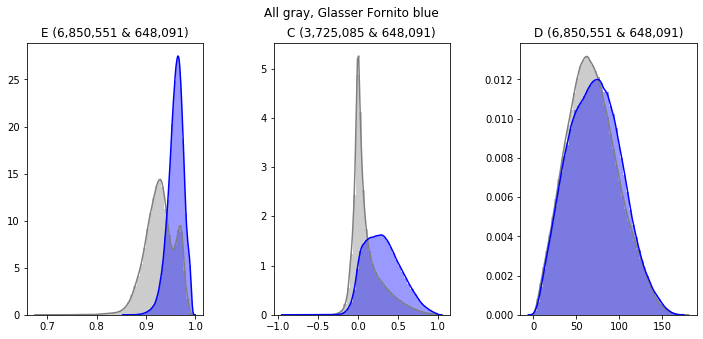

In [8]:
fig, axes = dist_trio_overlapping(expr_all_vec, expr_vec, conn_all_vec, conn_vec, dist_all_vec, dist_vec, "All gray, Glasser Fornito blue")

In [9]:
""" Plot relationships between ES or CS vs D. """

import seaborn as sns
import matplotlib.pyplot as plt

def scatter_duo(ev, cv, desc=""):
    fig, axes = plt.subplots(ncols=2, figsize=(12, 7))

    sns.regplot(dist_vec, expr_vec, color='gray', scatter_kws={'s': 1}, ax=axes[0])
    axes[0].set_title("e")
    sns.regplot(dist_vec, conn_vec, color='gray', scatter_kws={'s': 1}, ax=axes[1])
    axes[1].set_title("c")

    fig.savefig('./scatters_{}.png'.format(desc))
    
    return fig, axes

In [10]:
""" Split vectors by values corresponding to proximate edges and distal edges. """

expr_prox_vec = expr_vec[dist_vec<=16]
expr_dist_vec = expr_vec[dist_vec>16]
conn_prox_vec = conn_vec[dist_vec<=16]
conn_dist_vec = conn_vec[dist_vec>16]
dist_prox_vec = dist_vec[dist_vec<=16]
dist_dist_vec = dist_vec[dist_vec>16]


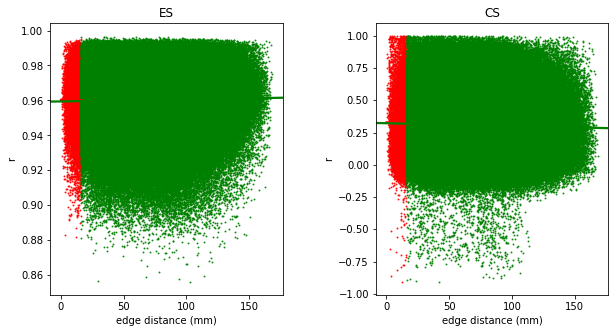

In [14]:
""" Plot relationships between ES or CS vs D, by distance threshold. """

import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=2, sharey=False, figsize=(10, 5))

sns.regplot(dist_prox_vec, expr_prox_vec, color='red', scatter_kws={'s': 1}, ax=axes[0])
sns.regplot(dist_dist_vec, expr_dist_vec, color='green', scatter_kws={'s': 1}, ax=axes[0])
axes[0].set_title("ES")
axes[0].set_xlabel("edge distance (mm)")
axes[0].set_ylabel("r")

sns.regplot(dist_prox_vec, conn_prox_vec, color='red', scatter_kws={'s': 1}, ax=axes[1])
sns.regplot(dist_dist_vec, conn_dist_vec, color='green', scatter_kws={'s': 1}, ax=axes[1])
axes[1].set_title("CS")
axes[1].set_xlabel("edge distance (mm)")
axes[1].set_ylabel("r")

fig.subplots_adjust(wspace=0.4)
fig.savefig('./scatters.png')